In [1]:
import os
import numpy as np
import jams
from scipy.io import wavfile
import sys
import librosa
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
annotation_folder = "audio/GuitarSet/annotation/"
audio_folder = "audio/GuitarSet/audio/"
output = {}
hop_length = 512
sr_curr = 22050
cqt_n_bins = 288
cqt_bins_per_octave = 36
string_midi_pitches = [40,45,50,55,59,64]
highest_fret = 19
num_classes = highest_fret + 2
matrix = np.zeros(shape=(6, 21)).astype(int)

In [3]:
def preprocess_audio(data):
    data = data.astype(float)
    data = librosa.util.normalize(data)
    data = np.abs(librosa.cqt(data,
                              hop_length=hop_length,
                              sr=sr_curr,
                              n_bins=cqt_n_bins,
                              bins_per_octave=cqt_bins_per_octave))

    return data

In [4]:
def correct_numbering(n):
    n += 1
    if n < 0 or n > highest_fret:
        n = 0
    return n

def categorical(label):
    return to_categorical(label, num_classes)

In [5]:
def clean_label(label):
    label = [correct_numbering(n) for n in label]
    return categorical(label)

In [6]:
def clean_labels(labels):
    return np.array([clean_label(label) for label in labels])

In [7]:
def load_rep_and_labels_from_raw_file(filename):
    output = {}
    file_audio = audio_folder + filename + "_mic.wav"
    file_anno = annotation_folder + filename + ".jams"
    jam = jams.load(file_anno)
    data, _ = librosa.load(file_audio, sr=sr_curr)

    # preprocess audio, store in output dict
    output["repr"] = np.swapaxes(preprocess_audio(data),0,1)

    # construct labels
    frame_indices = range(len(output["repr"]))
    times = librosa.frames_to_time(frame_indices, sr = sr_curr, hop_length=hop_length)

    # loop over all strings and sample annotations
    labels = []
    for string_num in range(6):
        anno = jam.annotations["note_midi"][string_num]
        string_label_samples = anno.to_samples(times)
        # replace midi pitch values with fret numbers
        for i in frame_indices:
            if string_label_samples[i] == []:
                string_label_samples[i] = -1
            else:
                string_label_samples[i] = int(round(string_label_samples[i][0]) - string_midi_pitches[string_num])
        labels.append([string_label_samples])

    labels = np.array(labels)
    # remove the extra dimension
    labels = np.squeeze(labels)
    labels = np.swapaxes(labels,0,1)

    # clean labels
    labels = clean_labels(labels)

    # store and return
    output["labels"] = labels
    labels = labels.astype(int)
    sum_labels = np.zeros((6, 21)).astype(int)
    for label in labels:
        sum_labels += label
    return sum_labels

In [8]:
for file in os.listdir(annotation_folder):
    file = file.replace('.jams', '')
    l = load_rep_and_labels_from_raw_file(file)
    matrix += l
    print(f"file {file} done")

file 00_BN1-129-Eb_comp done
file 00_BN1-129-Eb_solo done
file 00_BN1-147-Gb_comp done
file 00_BN1-147-Gb_solo done
file 00_BN2-131-B_comp done
file 00_BN2-131-B_solo done
file 00_BN2-166-Ab_comp done
file 00_BN2-166-Ab_solo done
file 00_BN3-119-G_comp done
file 00_BN3-119-G_solo done
file 00_BN3-154-E_comp done
file 00_BN3-154-E_solo done
file 00_Funk1-114-Ab_comp done
file 00_Funk1-114-Ab_solo done
file 00_Funk1-97-C_comp done
file 00_Funk1-97-C_solo done
file 00_Funk2-108-Eb_comp done
file 00_Funk2-108-Eb_solo done
file 00_Funk2-119-G_comp done
file 00_Funk2-119-G_solo done
file 00_Funk3-112-C#_comp done
file 00_Funk3-112-C#_solo done
file 00_Funk3-98-A_comp done
file 00_Funk3-98-A_solo done
file 00_Jazz1-130-D_comp done
file 00_Jazz1-130-D_solo done
file 00_Jazz1-200-B_comp done
file 00_Jazz1-200-B_solo done
file 00_Jazz2-110-Bb_comp done
file 00_Jazz2-110-Bb_solo done
file 00_Jazz2-187-F#_comp done
file 00_Jazz2-187-F#_solo done
file 00_Jazz3-137-Eb_comp done
file 00_Jazz3-137-Eb_

In [9]:
print(matrix)

[[391605  14206  10547   8603  11749  11997   5728  10054   3193   2337
    1382    949    110     85      0     15      0      0      0      0
       0]
 [341931   8633   4949  15087  18338  23117  10964  21806   8772  11183
    3623   1845   1331    974      7      0      0      0      0      0
       0]
 [295962  10222   1981  18453  24220  17022  16413  27492  14570  22226
    8580   8574   4112   1930    639     87     23      8      7     39
       0]
 [284939  10936  10330  14937  19443  16445  17602  29853  20372  18261
   10953   9733   4466   2178   1239    164    624     26     35     24
       0]
 [311644  11127  11526  11970  14274  15887  13596  22385  12848  17467
   10300   8383   5140   2554   2341    519    355    215     29      0
       0]
 [391966   9563   5839   5427   7155   8415   7740  10041   4719   7719
    4240   4468   1777   1745   1197    288    105    145     11      0
       0]]


In [10]:
EStringLabels = matrix[0].tolist()[1:]
AStringLabels = matrix[1].tolist()[1:]
DStringLabels = matrix[2].tolist()[1:]
GStringLabels = matrix[3].tolist()[1:]
BStringLabels = matrix[4].tolist()[1:]
eStringLabels = matrix[5].tolist()[1:]
print(f"E string: {EStringLabels}")
print(f"A string: {AStringLabels}")
print(f"D string: {DStringLabels}")
print(f"G string: {GStringLabels}")
print(f"B string: {BStringLabels}")
print(f"e string: {eStringLabels}")

E string: [14206, 10547, 8603, 11749, 11997, 5728, 10054, 3193, 2337, 1382, 949, 110, 85, 0, 15, 0, 0, 0, 0, 0]
A string: [8633, 4949, 15087, 18338, 23117, 10964, 21806, 8772, 11183, 3623, 1845, 1331, 974, 7, 0, 0, 0, 0, 0, 0]
D string: [10222, 1981, 18453, 24220, 17022, 16413, 27492, 14570, 22226, 8580, 8574, 4112, 1930, 639, 87, 23, 8, 7, 39, 0]
G string: [10936, 10330, 14937, 19443, 16445, 17602, 29853, 20372, 18261, 10953, 9733, 4466, 2178, 1239, 164, 624, 26, 35, 24, 0]
B string: [11127, 11526, 11970, 14274, 15887, 13596, 22385, 12848, 17467, 10300, 8383, 5140, 2554, 2341, 519, 355, 215, 29, 0, 0]
e string: [9563, 5839, 5427, 7155, 8415, 7740, 10041, 4719, 7719, 4240, 4468, 1777, 1745, 1197, 288, 105, 145, 11, 0, 0]


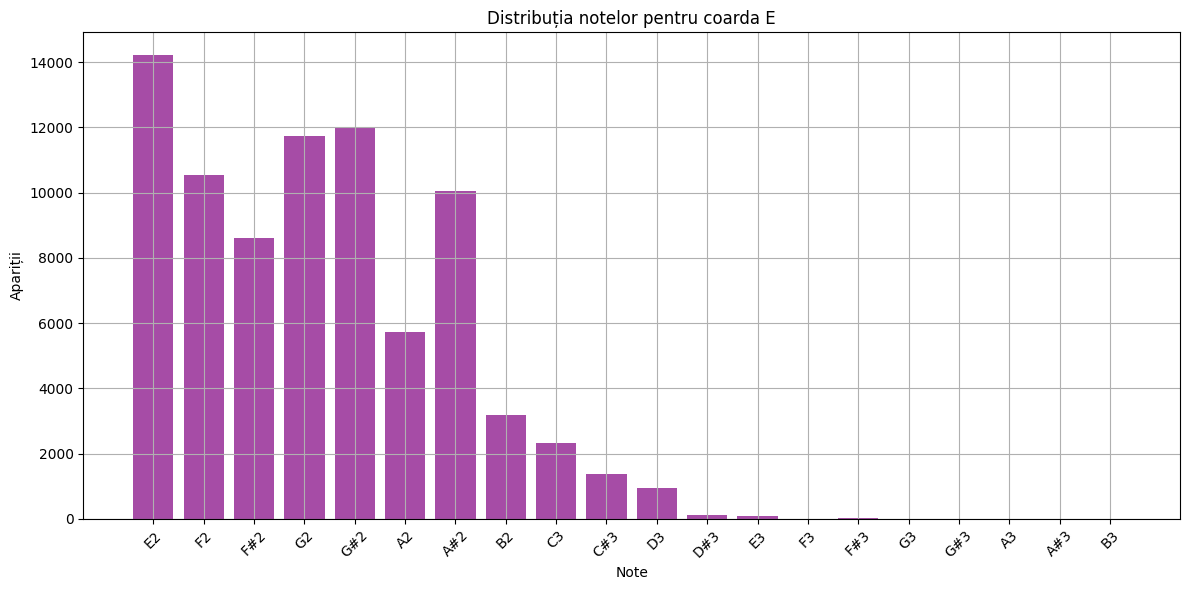

In [11]:
E_labels = ['E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2', 'B2', 'C3', 'C#3', 'D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'B3']

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(E_labels, EStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda E')
plt.xlabel('Note')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

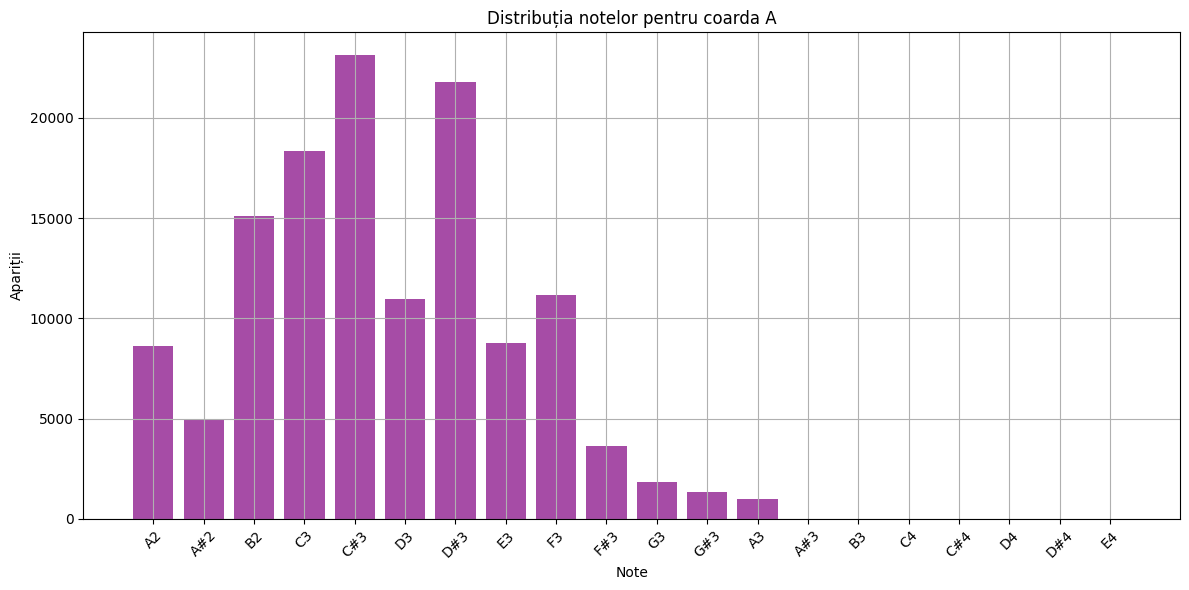

In [12]:
A_labels = ['A2', 'A#2', 'B2', 'C3', 'C#3', 'D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4']

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(A_labels, AStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda A')
plt.xlabel('Note')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

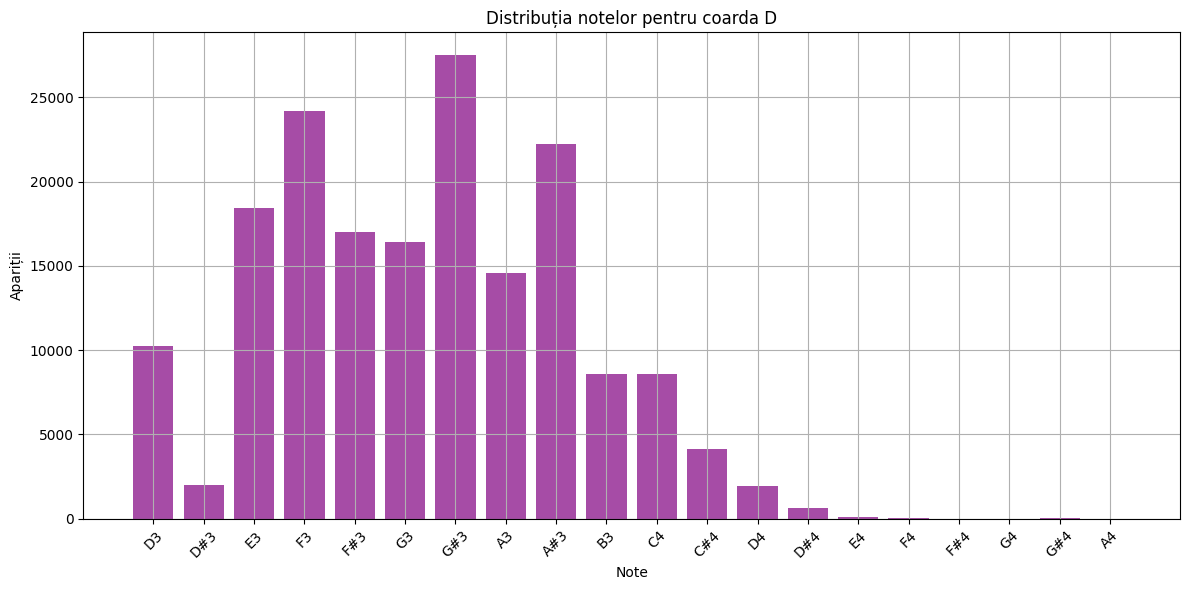

In [13]:
D_labels = ['D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4']

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(D_labels, DStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda D')
plt.xlabel('Note')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

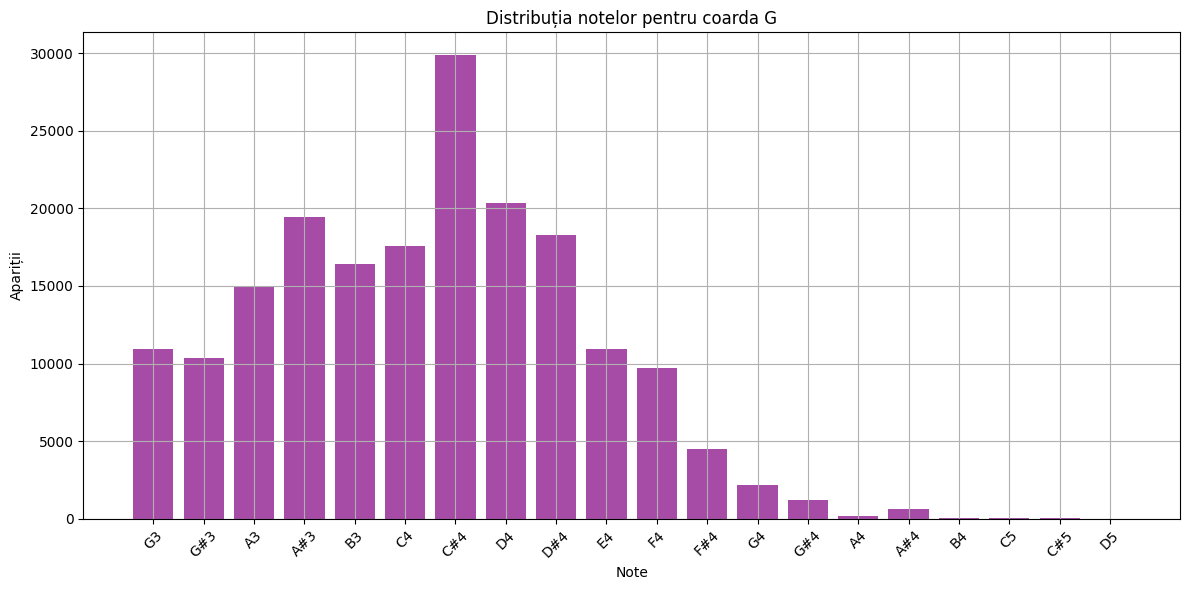

In [14]:
G_labels = ['G3', 'G#3', 'A3', 'A#3', 'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5', 'C#5', 'D5']

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(G_labels, GStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda G')
plt.xlabel('Note')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

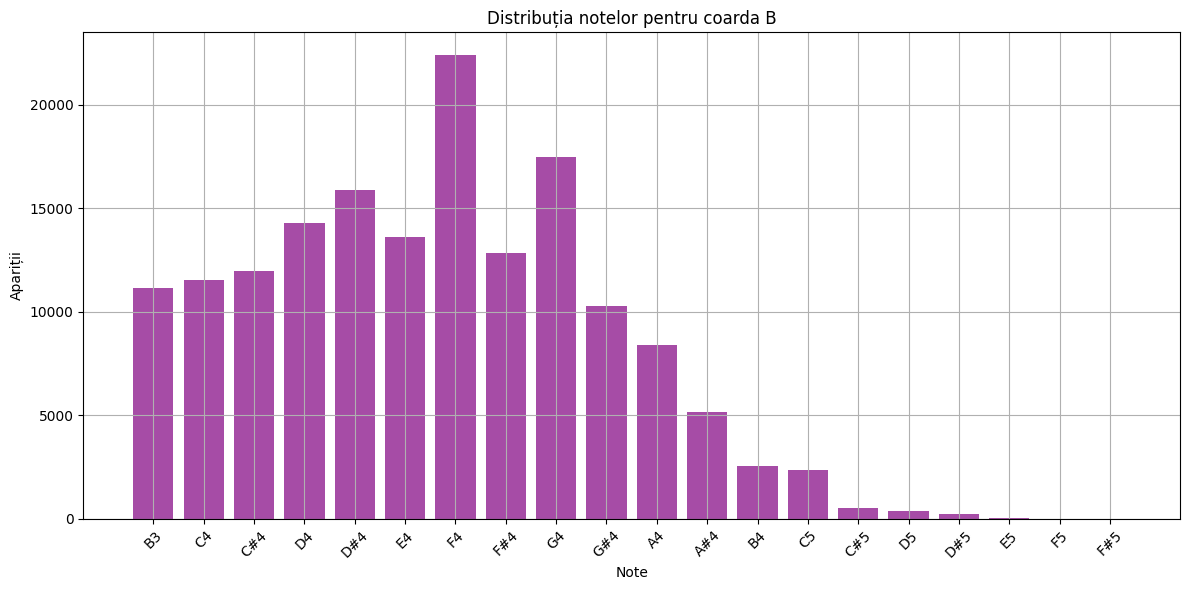

In [15]:
B_labels = ['B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5']

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(B_labels, BStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda B')
plt.xlabel('Note')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

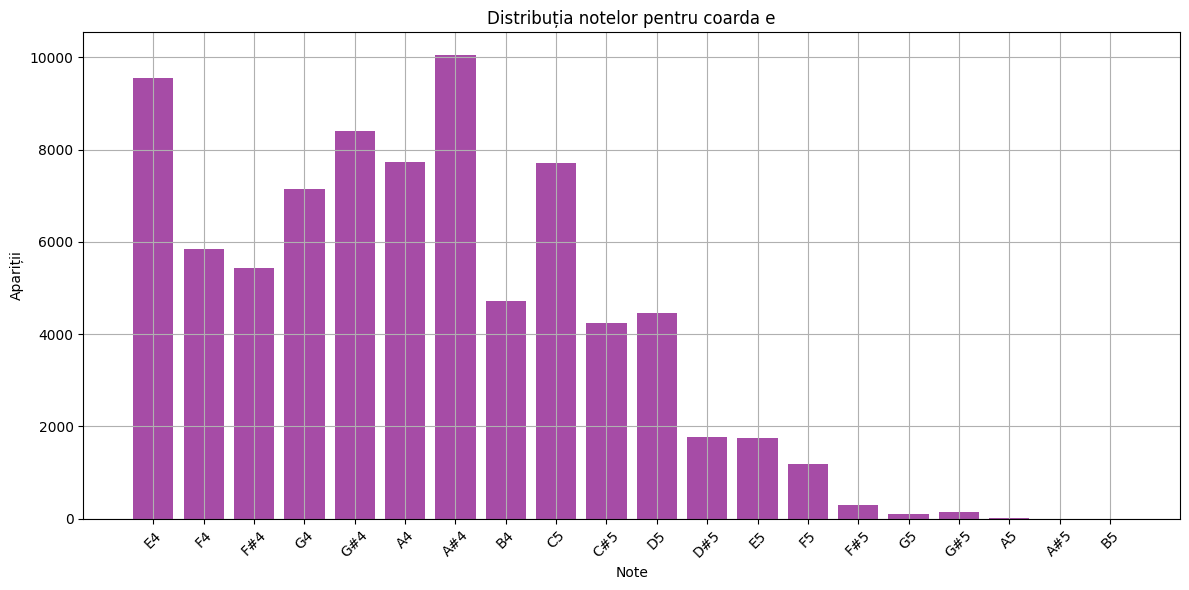

In [16]:
e_labels = ['E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'A#5', 'B5']

# Creating a bar chart with labels on the x-axis
plt.figure(figsize=(12, 6))
plt.bar(e_labels, eStringLabels, color='purple', alpha=0.7)
plt.title('Distribuția notelor pentru coarda e')
plt.xlabel('Note')
plt.ylabel('Apariții')
plt.xticks(rotation=45)  # Rotating the labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()